**0. Imports & Data Loading**

In [7]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_pinball_loss, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV, LassoCV
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from xgboost import XGBRegressor
import ipywidgets as w
from collections import OrderedDict
import yfinance as yf
import warnings


# Data Loading
CSV_FILE = r"C:\Users\prath\Desktop\GridVision\5. Data\Core Data\ES_8hr(06.2015-06.2025).csv"
df = pd.read_csv(CSV_FILE).loc[:, ~pd.read_csv(CSV_FILE).columns.str.contains(r'^Unnamed')]
df["DateTime"] = pd.to_datetime(df["DateTime"], utc=True).dt.tz_convert(None)

df.head()

,DateTime,Open,High,Low,Close,Volume(from bar)
0,2015-06-17 16:00:00,2088.75,2098.75,2078.75,2089.25,777269
1,2015-06-18 00:00:00,2089.00,2093.25,2082.00,2092.75,65379
2,2015-06-18 08:00:00,2092.50,2115.00,2085.50,2113.25,830221
3,2015-06-18 16:00:00,2113.00,2119.25,2110.00,2113.00,767533
4,2015-06-19 00:00:00,2113.00,2116.25,2111.50,2114.75,39932


**1. Core Feature Engineering**

In [8]:
# Core Features
df["range"] = df["High"] - df["Low"]
df["side"] = (df["Close"] >= df["Open"]).astype(int)
df["dayofweek"] = df["DateTime"].dt.dayofweek

# Session Mapping
# Sessions have distinct personalities, driven by different market participants. Mapping them could reveal time-dependent behavior.
def map_session(dt):
    hour = dt.hour
    return "AM" if hour == 8 else "PM" if hour == 16 else "AS" if hour == 0 else None

df["session"] = df["DateTime"].apply(map_session)

# Stochastic Oscillator
# Positions the close within a recent high-low range. Fear and greed often distort behavior near extremes, allowing us to map sentiment-inflected price zones.
low = df["Low"].rolling(111).min()
high = df["High"].rolling(111).max()
df["stoch_k"] = 100 * (df["Close"] - low) / (high - low)

# Candle Pattern Classification
# Classifies each candle by how its range and close relate to the previous bar, capturing structural setups like inside bars, breakouts, and exhaustion.
def classify_candle(df_):
    prev = df_.shift(1)
    h, l, c = df_["High"], df_["Low"], df_["Close"]
    ph, pl, po = prev["High"], prev["Low"], prev["Open"]

    rf = pd.Series(index=df_.index, dtype="object")  # Range filter
    rf[(h <= ph) & (l >= pl)] = "I"  # Inside
    rf[(h > ph) & (l >= pl)] = "U"   # Up
    rf[(l < pl) & (h <= ph)] = "D"   # Down
    rf.fillna("O", inplace=True)     # Outside

    cz = pd.Series(index=df_.index, dtype="object")  # Close zone
    cz[c > ph] = "H"     # Closed above prev high
    cz[c < pl] = "L"     # Closed below prev low
    cz[(c > po) & (c <= ph)] = "U"  # Mild bullish close
    cz.fillna("D", inplace=True)    # Default/mild bearish

    df_["pattern"] = rf + cz
    df_.loc[df_.index[0], "pattern"] = None  # No pattern on first row
    return df_
df = classify_candle(df)

# Breakout Count Features
# Counts how many recent highs/lows have been broken, quantifying structural pressure and potential liquidity shifts in market behavior.
def add_breakout_counts(df):
    lows, highs = df["Low"].values, df["High"].values
    lows_count, highs_count = [np.nan], [np.nan]

    for i in range(1, len(df)):
        prev_low, prev_high = lows[i-1], highs[i-1]
        
        # Starts from i-2 to avoid overlap with immediate past — ensures purely backward-looking structural context
        count_lows = sum(1 for j in range(i-2, -1, -1) if lows[j] > prev_low and lows[j] > lows[i-2])
        count_highs = sum(1 for j in range(i-2, -1, -1) if highs[j] < prev_high and highs[j] < highs[i-2])

        lows_count.append(count_lows)
        highs_count.append(count_highs)

    df["n_lows_taken_prev"]  = lows_count
    df["n_highs_taken_prev"] = highs_count
    return df
df = add_breakout_counts(df)

df.set_index("DateTime", inplace=True)
df = df[df["pattern"].notna() & (df["range"] > 0)].copy() 
df.head()


,Open,High,Low,Close,Volume(from bar),range,side,dayofweek,session,stoch_k,pattern,n_lows_taken_prev,n_highs_taken_prev
DateTime,,,,,,,,,,,,,
2015-06-18 00:00:00,2089.0,2093.25,2082.0,2092.75,65379,11.25,1,3,AS,NaN,IU,0.0,0.0
2015-06-18 08:00:00,2092.5,2115.00,2085.5,2113.25,830221,29.50,1,3,AM,NaN,UH,0.0,0.0
2015-06-18 16:00:00,2113.0,2119.25,2110.0,2113.00,767533,9.25,1,3,PM,NaN,UU,0.0,0.0
2015-06-19 00:00:00,2113.0,2116.25,2111.5,2114.75,39932,4.75,1,4,AS,NaN,IU,0.0,2.0
2015-06-19 08:00:00,2115.0,2117.75,2106.5,2107.25,586571,11.25,0,4,AM,NaN,OL,0.0,3.0


**2. Data Exploration**

In [9]:
# Interactive Filter Widgets
lookback   = w.IntSlider(value=24, min=6, max=120, step=6,
                         description="Look-back months")
session_dd = w.Dropdown(options=["All", "AM", "PM", "AS"], value="All",
                        description="Session")
side_dd    = w.Dropdown(options=["All", 1, 0], value="All",
                        description="Side")
pattern_dd = w.Dropdown(options=['All'] + sorted(df['pattern'].dropna().unique()),
    value='All', description='Pattern'
)

display(lookback, session_dd, side_dd, pattern_dd)

# Interactive Stats Viewer
def show_stats(months, sess, side, pattern):
    cutoff = df.index.max() - pd.DateOffset(months=months)
    sub = df[df.index >= cutoff]

    if sess != "All":
        sub = sub[sub["session"] == sess]
    if side != "All":
        sub = sub[sub["side"] == int(side)]
    if pattern != "All":
        sub = sub[sub["pattern"] == pattern]

    # Descriptive Statistics Table
    desc = sub["range"].describe(percentiles=[.25, .5, .75, .9]).round(2)
    display(desc.to_frame("range").style.format({"range": "{:.2f}"}))

    # Histogram Plot
    plt.figure(figsize=(6, 4))
    plt.hist(sub["range"], bins=30, edgecolor="k")
    title = f"Range distribution – {len(sub)} bars"
    if sess != "All":    title += f" | {sess}"
    if side != "All":    title += f" | side {side}"
    if pattern != "All": title += f" | pattern {pattern}"
    plt.title(title)
    plt.xlabel("Range")
    plt.ylabel("Frequency")
    plt.show()

# Display Interactive Output
out = w.interactive_output(
    show_stats,
    {"months": lookback, "sess": session_dd, "side": side_dd, "pattern": pattern_dd}
)

display(out)


IntSlider(value=24, description='Look-back months', max=120, min=6, step=6)

Dropdown(description='Session', options=('All', 'AM', 'PM', 'AS'), value='All')

Dropdown(description='Side', options=('All', 1, 0), value='All')

Dropdown(description='Pattern', options=('All', 'DD', 'DL', 'DU', 'ID', 'IU', 'OD', 'OH', 'OL', 'OU', 'UD', 'U…

Output()

- Most candles have small ranges, but a few large ones stretch the upper tail — mean is consistently higher than median, confirming a right-skewed distribution

- Narrower lookback windows (e.g. 24 months) show higher mean and standard deviation, pointing to increased volatility in recent market conditions likely reflecting macro uncertainty, liquidity shifts, and regime changes

- AM sessions show balanced range behavior with a moderate average, reflecting structured movement around London and NY opens.

- PM sessions display wider tails and higher variance, often driven by U.S. close dynamics, news events, and rebalancing flows.

- AS sessions are the most muted, with tighter distributions — typical of low liquidity and range-bound overnight price action.

- Downside candles (Side = 0) generally exhibit larger ranges than upside candles, suggesting more aggressive or disorderly selling.

- Pattern UH (upward expansion with a high close) is the most frequent pattern and produces the highest average ranges, reflecting the markets strong bullish conviction.


**3. One-Hot Encoding**

In [10]:
# Convert categorical features into numeric form for model compatibility 
df_OHE = df.copy()
df_OHE = df_OHE.drop(columns=["session", "pattern", "dayofweek"])
df_OHE = df_OHE.join([
    pd.get_dummies(df["session"], prefix="sess", dtype=float, drop_first=True),
    pd.get_dummies(df["pattern"], prefix="pat", dtype=float, drop_first=True),
    pd.get_dummies(df["dayofweek"], prefix="dow", dtype=float, drop_first=True),
])

df_OHE.head()



,Open,High,Low,Close,Volume(from bar),range,side,stoch_k,n_lows_taken_prev,n_highs_taken_prev,...,pat_OL,pat_OU,pat_UD,pat_UH,pat_UU,dow_1,dow_2,dow_3,dow_4,dow_6
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-06-18 00:00:00,2089.0,2093.25,2082.0,2092.75,65379,11.25,1,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2015-06-18 08:00:00,2092.5,2115.00,2085.5,2113.25,830221,29.50,1,NaN,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2015-06-18 16:00:00,2113.0,2119.25,2110.0,2113.00,767533,9.25,1,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2015-06-19 00:00:00,2113.0,2116.25,2111.5,2114.75,39932,4.75,1,NaN,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-06-19 08:00:00,2115.0,2117.75,2106.5,2107.25,586571,11.25,0,NaN,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**4. News Event Flags**

In [11]:
# News Event Feature Engineering
# Flag bars with high-impact economic events (CPI, FOMC, NFP) to capture possible news-driven volatility
NEWS_FILE = Path(r"C:\Users\prath\Desktop\GridVision\5. Data\Core Data\News(01.2007-7.2025).csv")
news = pd.read_csv(NEWS_FILE, dtype=str)
news["datetime"] = pd.to_datetime(news["Date"] + " " + news["Time"], errors="coerce")
news = news.dropna(subset=["datetime"])
news = news.query("Currency == 'USD' and Impact in ['H','M']").sort_values("datetime")

event_map = {
    "non-farm": "NFP", "employment change": "NFP",
    "fomc": "FOMC", "interest rate": "FOMC",
    "cpi": "CPI", "inflation": "CPI",
}
news["event_type"] = news["Event"].str.lower().apply(
    lambda name: next((v for k, v in event_map.items() if k in name), "Other")
)

def add_news_event_flags(df_range, df_news):
    df = df_range.copy()
    df["start"], df["end"] = df.index, df.index.to_series().shift(-1)
    df["is_cpi"], df["is_fomc"], df["is_nfp"] = 0, 0, 0

    for i, row in df.iterrows():
        if pd.isna(row["end"]): continue
        mask = (df_news["datetime"] >= row["start"]) & (df_news["datetime"] < row["end"])
        events = df_news.loc[mask, "event_type"].tolist()
        df.at[i, "is_cpi"]  = int("CPI"  in events)
        df.at[i, "is_fomc"] = int("FOMC" in events)
        df.at[i, "is_nfp"]  = int("NFP"  in events)

    return df.drop(columns=["start", "end"])

df_OHE = add_news_event_flags(df_OHE, news)
df_OHE[["is_cpi", "is_fomc", "is_nfp"]].head()


,is_cpi,is_fomc,is_nfp
DateTime,,,
2015-06-18 00:00:00,0,0,0
2015-06-18 08:00:00,1,0,0
2015-06-18 16:00:00,0,0,0
2015-06-19 00:00:00,0,0,0
2015-06-19 08:00:00,0,0,0


**5. Lag Features**

In [12]:
# Flag strong candles where the body is large relative to the range — a sign of momentum that may impact the next bar
df_OHE["is_strong_candle"] = ((df["Close"] - df["Open"]).abs() > 0.7 * df["range"]).astype(int).shift(1)

# Add lagged features for range and side to give the model short-term memory and help it learn from recent volatility and direction
for k in range(1, 7):
    df_OHE[f"range_m{k}"] = df_OHE["range"].shift(k)
    df_OHE[f"side_m{k}"] = df_OHE["side"].shift(k)

# Add lagged versions of each candle pattern 
for k in (1, 2, 3):
    for col in [c for c in df_OHE.columns if c.startswith("pat_") and "_m" not in c]:
        df_OHE[f"{col}_m{k}"] = df_OHE[col].shift(k)

# Shift the stochastic oscillator forward so it's aligned as a predictive input, preventing look-ahead bias
df_OHE["stoch_k"] = df_OHE["stoch_k"].shift(1)
df_OHE = df_OHE.dropna()


**6. Train-Test Split**

In [13]:
# Remove extreme outliers from the dataset 
df_trim = df_OHE[df_OHE["range"] <= df_OHE["range"].quantile(0.95)].copy()

# Focus only on recent data from 2021 onward to reflect evolving market regimes
df_trim_small = df_trim[df_trim.index >= pd.Timestamp("2021-01-01")].copy()

# Split chronologically at Jan 2024 to preserve temporal causality
train_cutoff = pd.Timestamp("2024-01-01")
train_mask = df_trim_small.index < train_cutoff
train, test = df_trim_small[train_mask], df_trim_small[~train_mask]

# Feature set for models 
core_feats     = [f"range_m{k}" for k in range(1, 7)] + [f"side_m{k}" for k in range(1, 7)]
lag_pat_cols   = [c for c in df_OHE.columns if c.startswith("pat_") and "_m" in c]
sess_cols      = [c for c in df_OHE.columns if c.startswith("sess_")]
dow_cols       = [c for c in df_OHE.columns if c.startswith("dow_")]
event_flags    = ["is_cpi", "is_fomc", "is_nfp"]
breakout_cols  = ["n_lows_taken_prev", "n_highs_taken_prev"]

features = core_feats + sess_cols + dow_cols + lag_pat_cols + ["stoch_k"] + ["is_strong_candle"] + event_flags + breakout_cols

# Final model inputs
X_train, y_train = train[features], train["range"]
X_test, y_test   = test[features],  test["range"]


**7. Linear Models**

                            OLS Regression Results                            
Dep. Variable:                  range   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     29.34
Date:                Sun, 13 Jul 2025   Prob (F-statistic):          1.15e-180
Time:                        13:28:49   Log-Likelihood:                -4149.0
No. Observations:                1105   AIC:                             8418.
Df Residuals:                    1045   BIC:                             8718.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 38.0524      7

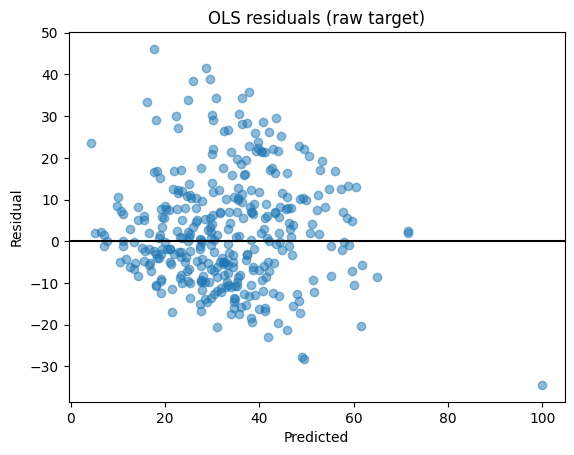

In [14]:
# Ordinary Least Squares with intercept 
ols_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
ols_pred = ols_model.predict(sm.add_constant(X_test))
mae_ols = mean_absolute_error(y_test, ols_pred)

# Ridge & Lasson regressions: Add penalties to stabilize coefficients
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0]).fit(X_train, y_train)
lasso = LassoCV(cv=5).fit(X_train, y_train)

mae_ridge = mean_absolute_error(y_test, ridge.predict(X_test))
mae_lasso = mean_absolute_error(y_test, lasso.predict(X_test))

# Huber regression: robust to heteroskedasticity and transient outliers via adaptive loss
huber = sm.RLM(y_train, sm.add_constant(X_train), M=sm.robust.norms.HuberT()).fit()
huber_pred = huber.predict(sm.add_constant(X_test))
mae_huber = mean_absolute_error(y_test, huber_pred)

# Summary
print(ols_model.summary())
print("Linear Model MAEs:")
print(f"OLS MAE         : {mae_ols:.2f} pts")
print(f"Ridge MAE       : {mae_ridge:.2f} pts")
print(f"Lasso MAE       : {mae_lasso:.2f} pts")
print(f"Huber MAE       : {mae_huber:.2f} pts")

# Residual diagnostics
plt.scatter(ols_pred, test["range"] - ols_pred, alpha=0.5)
plt.axhline(0, color="k")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("OLS residuals (raw target)")
plt.show()


- The model explains 62% of the variation in 8-hour range — a strong result given the complexity and noise typical in financial time series

- The F-statistic (29.15, p < 1e-179) confirms that the model as a whole is statistically meaningful — at least some predictors contribute real explanatory power

- Lagged range variables, especially range_m3 and range_m6, show high significance — capturing short-term memory and volatility clustering effects in price behavior

- Stochastic momentum (stoch_k) is strongly negative, suggesting that overbought conditions often lead to mean-reversion or range contraction in the following bar

- Session timing matters: sess_AS and sess_PM have significant negative effects on range — reflecting overnight quiet and post-EU slowdown respectively

- Sunday overnight (dow_6) has the lowest ranges, aligning with low liquidity and institutional inactivity during this session

- Most pattern-based features have weak significance — likely due to multicollinearity or non-linear interactions not captured in OLS

- pat_UH_m1 (upward expansion with high close) shows mild significance and aligns with intuitive behavior: strong bullish conviction leads to larger candles

- CPI events approach statistical significance, hinting at macro-driven range expansion — but the signal isn’t fully stable in linear form

- Residuals exhibit tighter, more homoskedastic spread around zero, indicating improved error stability across predictions. This followed exclusion of the top 5% range outliers via a 95th percentile cutoff, mitigating distortion from extreme volatility.


**8. Random Forest**

In [15]:
rf = RandomForestRegressor(n_estimators=333, max_depth=None, random_state=11)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, rf_pred)
print("RF MAE:", round(mae_rf,2), "pts")


RF MAE: 10.77 pts


- The Random Forest MAE (10.78 pts) is slightly higher than OLS MAE (10.30 pts), suggesting that the linear model is capturing the signal more effectively in this case — likely because the target (8-hour range) has a strong linear dependence on the input features, and the additional complexity of RF doesn't yield a performance gain.

**9. Gradient Boosting (Point & Quantile Forecasting)**

GBR MAE         : 10.59 pts
GBR Quantile τ=0.5   pinball loss: 5.23
GBR Quantile τ=0.75  pinball loss: 4.73
GBR Quantile τ=0.9   pinball loss: 3.15
τ = 0.5  • Empirical coverage = 0.453 (target = 0.5)
τ = 0.75 • Empirical coverage = 0.673 (target = 0.75)
τ = 0.9  • Empirical coverage = 0.785 (target = 0.9)


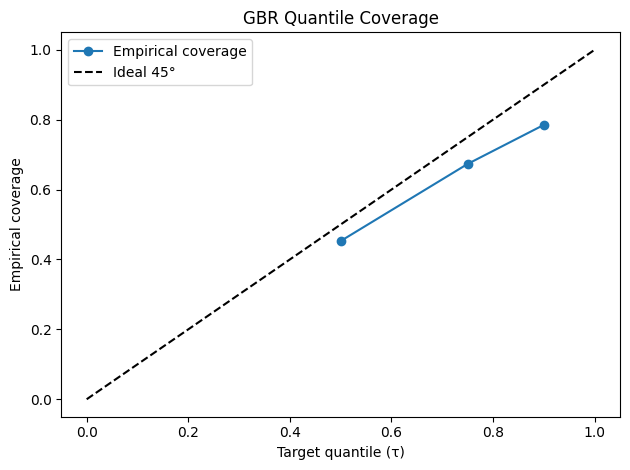

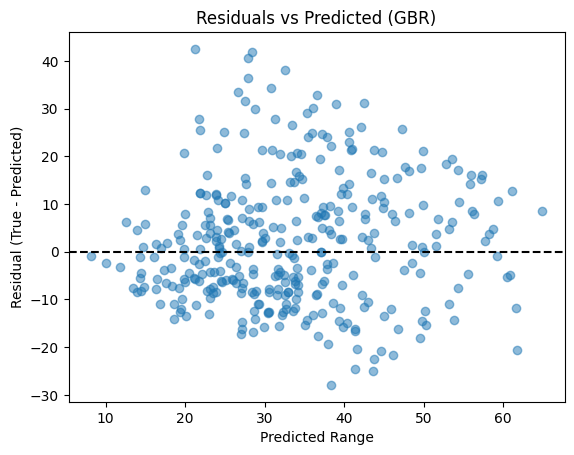

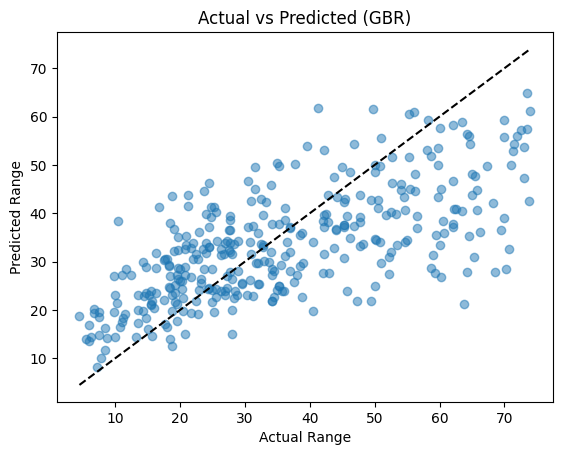

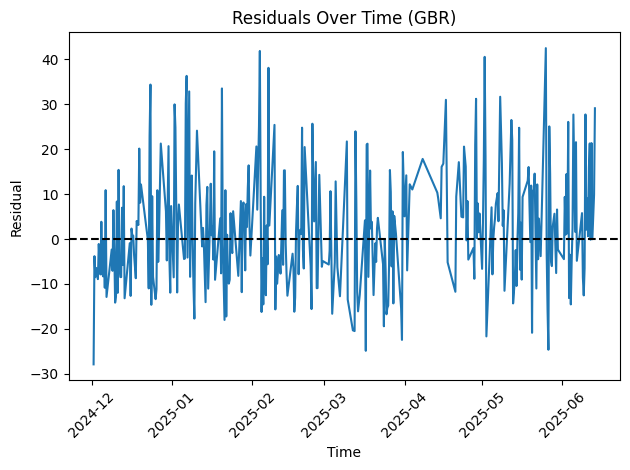

In [16]:
# Hyperparameter tuning for GBR using TimeSeriesSplit
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [2, 4, 6],
    'subsample': [0.6, 0.85, 1.0]
}

grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=11),
    param_grid,
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(n_splits=3),
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_gbr = grid_search.best_estimator_

# Fit best GBR model and evaluate MAE
best_gbr.fit(X_train, y_train)
gbr_pred = best_gbr.predict(X_test)
mae_gbr = mean_absolute_error(y_test, gbr_pred)
print(f"GBR MAE         : {mae_gbr:.2f} pts")

# Quantile regression with pinball loss evaluation
tau_list = [0.5, 0.75, 0.9]
gbr_q_preds = {}
for tau in tau_list:
    gbr_q = GradientBoostingRegressor(
        loss="quantile", alpha=tau, n_estimators=600,
        learning_rate=0.05, max_depth=3, subsample=0.8, random_state=42
    )
    gbr_q.fit(X_train, y_train)
    pred = gbr_q.predict(X_test)
    gbr_q_preds[tau] = pred
    pinball = mean_pinball_loss(y_test, pred, alpha=tau)
    print(f"GBR Quantile τ={tau:<4}  pinball loss: {pinball:.2f}")

# Quantile Calibration- comparing empirical coverage against target τ for each quantile 
calib_results = OrderedDict()

for tau, preds in gbr_q_preds.items():
    # Empirical coverage: fraction of true values ≤ predicted quantile
    coverage = np.mean(y_test <= preds)
    calib_results[tau] = coverage
    print(f"τ = {tau:<4} • Empirical coverage = {coverage:.3f} (target = {tau})")

taus   = list(calib_results.keys())
covers = list(calib_results.values())

plt.plot(taus, covers, marker='o', label='Empirical coverage')
plt.plot([0, 1], [0, 1], 'k--', label='Ideal 45°')
plt.xlabel("Target quantile (τ)")
plt.ylabel("Empirical coverage")
plt.title("GBR Quantile Coverage")
plt.legend()
plt.tight_layout()
plt.show()

# Residuals vs Predicted
residuals = y_test - gbr_pred
plt.scatter(gbr_pred, residuals, alpha=0.5)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Predicted Range")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals vs Predicted (GBR)")
plt.show()

# Actual vs Predicted
plt.scatter(y_test, gbr_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Range")
plt.ylabel("Predicted Range")
plt.title("Actual vs Predicted (GBR)")
plt.show()

# Residuals over time
plt.plot(y_test.index, residuals)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Residual")
plt.title("Residuals Over Time (GBR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- Gradient Boosting achieves a MAE of 10.59 points, with stable generalization across the test set 

- Quantile forecasts reveal consistent undercoverage across all target levels (τ = 0.5, 0.75, 0.9), indicating that predicted values systematically fall short of realized ranges — particularly during high-volatility ranges

- Actual vs predicted plot confirms that the model captures the central range distribution well, but increasingly underpredicts as true ranges exceed ~50 points — reflecting challenges in tail generalization

- Residuals widen as predicted ranges increase, creating a  spread that reflects conditional heteroskedasticity 

- The model’s limitations appear structural rather than parametric — primarily driven by tail sparsity and reduced responsiveness during periods of heightened market stress or volatility regime transitions

- Future improvements may involve post-hoc quantile calibration, tail-aware features, and hybrid volatility modeling to enhance reliability of uncertainty estimates and tail coverage

- While Gradient Boosting yields a slightly higher MAE than simpler linear models, it offers a critical advantage- access to quantile forecasts. These quantiles enable probabilistic range estimation, uncertainty banding, and risk-aware decision support — making it the most suitable foundation for deployment in the live Streamlit dashboard

**10. SARIMAX**

In [17]:
# Suppress non-critical warnings from Statsmodels and Pandas
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    sarimax = sm.tsa.statespace.SARIMAX(
        y_train,
        exog = sm.add_constant(X_train),
        order = (3, 0, 1),                  # AR(3), no differencing, MA(1)
        enforce_stationarity   = False,     # Relax stationarity requirement
        enforce_invertibility  = False      # Allow flexible MA structure
    )


    sarimax_fit   = sarimax.fit(disp=False)
    sarimax_pred  = sarimax_fit.get_forecast(
                        steps=len(y_test),
                        exog=sm.add_constant(X_test)
                    ).predicted_mean

# Evaluate forecast
mae_sarimax = mean_absolute_error(y_test, sarimax_pred)
print(f"SARIMAX MAE: {mae_sarimax:.2f} pts")


SARIMAX MAE: 10.38 pts


- The SARIMAX model achieves a MAE of 10.38 points — identical to OLS — confirming that the temporal dynamics are already well captured by the engineered lag features within the exogenous regressors, leaving little residual autocorrelation for the ARMA terms to improve upon

 **11. Final Benchmarking**


In [18]:
# Benchmark Comparsion
benchmark_df = pd.DataFrame({
    "Model": ["OLS", "Ridge", "Lasso", "Huber", "Random Forest", "Gradient Boosting", "SARIMAX", "Naive: Last Bar", "Naive: 3rd Last Bar", "Naive: ATR(10)"],
    "MAE": [
        mean_absolute_error(y_test, ols_pred),
        mean_absolute_error(y_test, ridge.predict(X_test)),
        mean_absolute_error(y_test, lasso.predict(X_test)),
        mean_absolute_error(y_test, huber.predict(sm.add_constant(X_test))),
        mean_absolute_error(y_test, rf.predict(X_test)),
        mean_absolute_error(y_test, gbr_pred),
        mean_absolute_error(y_test, sarimax_pred),
        mean_absolute_error(y_test, test["range_m1"]),
        mean_absolute_error(y_test, test["range_m3"]),
        mean_absolute_error(y_test.loc[test["range"].rolling(10).mean().shift(1).notna()], test["range"].rolling(10).mean().shift(1).dropna())
    ]
}).sort_values("MAE", ascending=True)

# Permutation Importance (Gradient Boosting)
gbr_imp = permutation_importance(
    estimator      = best_gbr,     
    X              = X_test,
    y              = y_test,
    n_repeats      = 20,
    random_state   = 33,
    n_jobs         = -1            
)

gbr_importances = (
    pd.DataFrame({
        "Feature"   : X_test.columns,
        "Importance": gbr_imp.importances_mean
    })
    .sort_values("Importance", ascending=False)
    .head(15)                      # top 15
)

display(benchmark_df.style.format({"MAE": "{:.2f}"}).set_caption("Model MAE Comparison"))
print(f"GBR vs Naive-3rd-Bar: {100*(mean_absolute_error(y_test, test['range_m3'])-mean_absolute_error(y_test, gbr_pred))/mean_absolute_error(y_test, test['range_m3']):.1f}% improvement  (GBR MAE {mean_absolute_error(y_test, gbr_pred):.2f} vs {mean_absolute_error(y_test, test['range_m3']):.2f} Naive)")
display(gbr_importances.style.format({"Importance": "{:.4f}"}).set_caption("Top 15 GBR Permutation Importances"))






,Model,MAE
0,OLS,10.38
6,SARIMAX,10.38
1,Ridge,10.48
3,Huber,10.48
5,Gradient Boosting,10.59
4,Random Forest,10.77
2,Lasso,12.67
9,Naive: ATR(10),14.62
8,Naive: 3rd Last Bar,21.07
7,Naive: Last Bar,26.07


GBR vs Naive-3rd-Bar: 49.8% improvement  (GBR MAE 10.59 vs 21.07 Naive)


,Feature,Importance
12,sess_AS,0.2825
52,stoch_k,0.1046
2,range_m3,0.0963
18,dow_6,0.0766
57,n_lows_taken_prev,0.0275
0,range_m1,0.0246
5,range_m6,0.0176
6,side_m1,0.0085
28,pat_UH_m1,0.0032
1,range_m2,0.0030


- OLS and SARIMAX tie for best point accuracy at 10.38 pts MAE, confirming that lagged-range, session, and weekday features already absorb most serial dependence

- Ridge and Huber track within +0.1 pt, showing the signal is stable; Lasso drops key lags and slips to 12.67 pts, evidencing under-fit when sparsity is forced

- Gradient Boosting lands at 10.59 pts—only ≈ 2 % off the linear top-line yet 49.8 % better than the 3-bar naive baseline—making it both competitive and probabilistic

- ATR-10 naive shrinks error versus raw persistence but still trails GBR by ≈ 28 %, highlighting the importance of momentum features and explicit session context

- Permutation importance confirms that session context and short-term volatility dominate predictive power, with liquidity-sweep counts following and candle-pattern lags adding useful extra texture

- Action path: anchor on OLS for baseline transparency, roll GBR into the dashboard for confidence bands, then pursue post-hoc coverage calibration  and add live probability updates keyed off the first-15-minute range